In [3]:
import numpy as np
import pandas as pd
import os 
from astropy.io import fits
import datetime as dt
import matplotlib.pyplot as plt

Check the fitted spectrums by running the cells below. 
It will randomly select a fitted spectrum and plot it

In [4]:
# Des
element_channels = {
    'Mg': (1.25 ),  # 1.25 keV
    'Al': (1.49 ),  # 1.49 keV
    'Si': (1.74 ),  # 1.74 keV
    'Ca': (3.69 ),  # 3.69 keV
    'Ti': (4.51 ),  # 4.51 keV
    'Cr': (5.41 ),  # 5.41 keV
    'Fe': (6.40 ),  # 6.40 keV
    'O': (0.525 )   # 0.525 keV
}

In [5]:
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian

In [6]:
def powerlaw(x,a,c,m):
    return a*((x-c)**m)

15.38638315387939
2022-02-02T10:19:11.538
[np.float64(28.64395582738436), np.float64(55.64262721290446), np.float64(55.81526699154799), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[np.float64(1.25), np.float64(1.49), np.float64(1.74), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[np.float64(0.125), np.float64(0.0641348001109579), np.float64(0.0656294158386614), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
ch2_cla_l120220202T101911
ch2_cla_l1_20220202T101911538_20220202T101919538.fits
2022-02-02T10:19:11.538


invalid value encountered in power


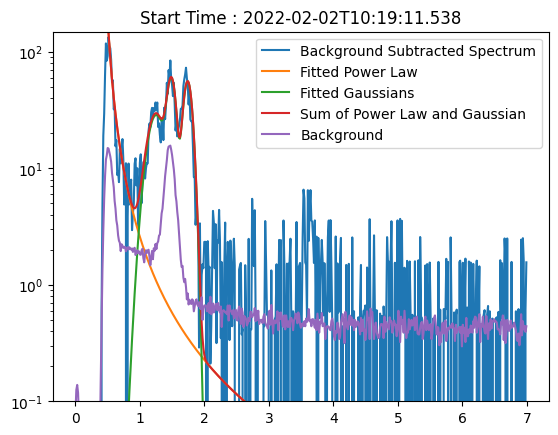

In [ ]:
data_path = 'ENTER THE PARENT PATH OF ALL DATA'
year   = np.random.randint(2019,2025)
months = os.listdir(f'xrf_line_catalog_power_law/{year}')
month_file  = months[np.random.randint(0,len(months))]
data=  pd.read_csv(os.path.join(f'xrf_line_catalog_power_law/{year}', month_file))
x = np.random.randint(0,len(data))
amp = [0]*8
mean =  [0]*8
sigma = [0]*8
a,c,m = data['Solar_spec_Amp'][x], data['Solar_spec_Energy'][x],  data['Solar_spec_Power'][x]
datetime  = data['Timestamp'][x]
print(data['Reduced_ChiSq'][x])
print(datetime)
# open(f'{year}/{month_file}.csv')
# print(a,c,m)

t1 = dt.datetime.strptime(datetime, "%Y-%m-%dT%H:%M:%S.%f")
t2=  t1+ dt.timedelta(seconds=8)
date = t1.day
date = str(date) if len(str(date))==2 else ('0'+ str(date))
ms= datetime[-4:-1]
h1 = t1.hour
h1 = str(h1) if len(str(h1))==2 else ('0'+str(h1))
m1 = t1.minute
m1 = str(m1) if len(str(m1))==2 else ('0'+str(m1))
s1 = t1.second
s1 = str(s1) if len(str(s1))==2 else ('0'+str(s1))

index = None
files= pd.read_csv(f'{year}/{month_file[0:2]}/{date}.csv', header=None)
for i in range(len(files)):
    flare_files = files[0][i].replace('\n', '').replace('[', '').replace(']', '').replace('\'', '').split()
    for file in flare_files:
        if file.startswith(f'ch2_cla_l1_{year}{month_file[0:2]}{date}T{h1}{m1}{s1}'):
            index = i
            break

back_files = files[1][index].replace('\n', '').replace('[', '').replace(']', '').replace('\'', '').split()
for i in range(len(back_files)):
                date_data_path  = f"{data_path}/ch2_cla_l1_{back_files[i][11:15]}_{back_files[i][15:17]}/cla/data/calibrated/{back_files[i][11:15]}/{back_files[i][15:17]}/{back_files[i][17:19]}/"
                if i==0:
                    back_data = [fits.open(date_data_path+ back_files[i])[1].data['counts']]*len(back_files)
                else:
                    back_data[i]=   fits.open(date_data_path+ back_files[i])[1].data['counts']
bg = np.sum(back_data, axis=0)/len(back_files)
for element,j in zip(list(element_channels.keys()), range(8)):
    amp[j] = data[f'Peak_Amplitude@{element}'][x]
    mean[j] = data[element][x]
    sigma[j] = data[f'Sigma_{element}'][x]

print(amp)
print(mean)
print(sigma)

j = None
print(f'ch2_cla_l1{year}{month_file[0:2]}{date}T{h1}{m1}{s1}')
for i in os.listdir(f'{data_path}/ch2_cla_l1_{year}_{month_file[0:2]}/cla/data/calibrated/{year}/{month_file[0:2]}/{date}/'):
    if i.startswith(f'ch2_cla_l1_{year}{month_file[0:2]}{date}T{h1}{m1}{s1}'):
        if i.endswith('fits'):
            j = i
            break
print(j)
fits_file = os.path.join(f'{data_path}/ch2_cla_l1_{year}_{month_file[0:2]}/cla/data/calibrated/{year}/{month_file[0:2]}/{date}/',j)

spec =  fits.open(fits_file)[1].data
print(fits.open(fits_file)[1].header['startime'])
channels = spec['Channel']*13.5/1000
counts = spec['counts']
counts = counts[channels<7]
bg = bg[channels<7]
channels = channels[channels<7]


prediction1 =  powerlaw(channels, a,c,m)
plt.plot(channels, counts-bg, label  = 'Background Subtracted Spectrum')
plt.plot(channels, prediction1, label = 'Fitted Power Law')
prediction = [0]*len(channels)
for i in range(8):
    if np.isnan(amp[i]):
        continue
    else:
        prediction+= gaussian(np.array(channels), amp[i], mean[i], sigma[i])

plt.plot(channels, prediction, label = 'Fitted Gaussians')
plt.plot(channels, prediction+prediction1, label = 'Sum of Power Law and Gaussian')
plt.plot(channels, bg ,label = 'Background')
plt.ylim(0.1, 1*np.max(counts))
plt.legend()
plt.title(f'Start Time : {datetime}')
plt.yscale('log')
plt.savefig('spectrum_components6.jpg', dpi =400)